### Import some libraries

In [1]:
import arcpy
import os

### Set up some files and geodatabases

In [6]:
notebook_directory = os.getcwd()
dsm_gdb = os.path.join(os.getcwd(), "Buffered_DSMs.gdb")
asr_gdb = os.path.join(notebook_directory, "ASR_Rasters.gdb")
default_gdb = os.path.join(notebook_directory, "Default.gdb")
lidar_tiles = r"https://services1.arcgis.com/JIxJEU91T3GTguUM/arcgis/rest/services/Lidar_Tile_Index_2015/FeatureServer/0"
dsm_mosaic = os.path.join(default_gdb, "Lethbridge_DSM")

### Tile summaries

Lets summarize the tiles by how many buildings are within them

In [11]:
import pandas as pd
tile_data = [r for r in arcpy.da.SearchCursor(lidar_tiles, ['Label', 'Buildings_Over_10m'])]
df = pd.DataFrame.from_records(tile_data, columns=['label', 'building_count']).sort_values(by='building_count', ascending=False)
df

,label,building_count
122,845_5509,2085
111,845_5508,2049
112,855_5508,1996
130,855_5510,1973
75,855_5505,1957
...,...,...
1,795_5498,0
115,885_5508,0
117,795_5509,0
126,885_5509,0


If we plot this is a histogram, we can see the distribution of building counts

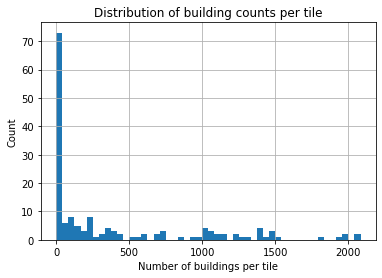

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

bins=50
histogram = df['building_count'].hist(bins=bins)
histogram.set_title("Distribution of building counts per tile")
histogram.set_xlabel("Number of buildings per tile")
histogram.set_ylabel("Count")
plt.show()

As we can see, many of the tiles have relatively few buildings. Here is the break down of the smallest of the bins from the histogram

In [25]:
pd.cut(df['building_count'], bins).value_counts().head()

(-2.085, 41.7]    73
(83.4, 125.1]      8
(208.5, 250.2]     8
(41.7, 83.4]       6
(125.1, 166.8]     5
Name: building_count, dtype: int64

So, to cut down on processing time, we can filter out tiles that have a small number of buildings. For argument's sake, let's choose 15 as the minimum number

In [29]:
print(f"Number of tiles: {len(tile_data)}")

Number of tiles: 157


In [47]:
over_15_buildings = [t[0] for t in tile_data if t[1] >= 15]
print(f"Number of tiles with more than 15 buildings: {len(over_15_buildings)}")

Number of tiles with more than 15 buildings: 103


This will cut down processing time considerabley, while still allowing for interesting results

This processing is mostly already completed, and the rasters are available in the `asr_gdb` geodatabase. Here is the summary of those rasters

In [33]:
arcpy.env.workspace = asr_gdb
asr_rasters = arcpy.ListRasters("ASR*")
print(f"Number of ASR rasters computed: {len(asr_rasters)}")

Number of ASR rasters computed: 102


In [45]:
asr_raster_labels = [r.split("_", 1)[1] for r in asr_rasters]
asr_raster_labels.sort()
asr_raster_labels

['775_5505', '775_5507', '785_5499', '785_5503', '785_5504', '785_5505', '785_5506', '785_5507', '785_5508', '795_5500', '795_5503', '795_5504', '795_5505', '795_5506', '795_5507', '795_5508', '805_5502', '805_5503', '805_5504', '805_5505', '805_5506', '805_5507', '805_5508', '815_5501', '815_5502', '815_5503', '815_5504', '815_5505', '815_5506', '815_5507', '815_5508', '815_5509', '825_5502', '825_5503', '825_5504', '825_5505', '825_5506', '825_5508', '825_5509', '835_5502', '835_5504', '835_5505', '835_5506', '835_5507', '835_5508', '835_5509', '835_5510', '835_5511', '845_5501', '845_5502', '845_5504', '845_5505', '845_5506', '845_5507', '845_5508', '845_5509', '845_5510', '845_5511', '845_5512', '855_5502', '855_5503', '855_5504', '855_5505', '855_5506', '855_5507', '855_5508', '855_5509', '855_5510', '855_5511', '855_5512', '865_5501', '865_5502', '865_5503', '865_5504', '865_5505', '865_5506', '865_5507', '865_5508', '865_5509', '865_5510', '865_5511', '865_5512', '865_5513', '87

In [55]:
missing_tiles = [t for t in over_15_buildings if t not in asr_raster_labels]
f"Missing tiles: {', '.join(missing_tiles)}"

'Missing tiles: 775_5506'